<a href="https://colab.research.google.com/github/tmallmann/tmallmann/blob/main/people_detection_zone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecção de pessoas utilizando [YOLO V8](https://ultralytics.com/yolov8) e [SUPERVISION](https://supervision.roboflow.com/).

Tiago Mallmann
04.09.2023

In [ ]:
!nvidia-smi


Fri Dec 19 18:45:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 1. Instalação e importação do Ultralytics.

In [ ]:
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
print(ultralytics.checks())


Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 38.5/112.6 GB disk)
None


#2. Instalação e importação do Supervision.

In [ ]:
!pip install supervision

display.clear_output()

import supervision as sv
print("Supervision", sv.__version__)


Supervision 0.27.0


#3. Definição da mídia de entrada.
Faça o upload do seu vídeo para a pasta `/content`.

In [ ]:
import os

HOME = os.getcwd()
VIDEO_PATH = 'road.mp4' # Renomear com o nome do seu vídeo

# Para não carregar todo o vídeo na memória, é carregado um frame de cada vez utilizando o 'generator'
generator = sv.get_video_frames_generator(VIDEO_PATH)
frame = next(generator)

# Exibe o primeiro frame do vídeo
sv.plot_image(frame)

Exception: Could not open video at road.mp4

#4. Detecção de objetos em frame.


0: 704x1280 14 persons, 2 cars, 4 motorcycles, 4 trucks, 1 boat, 1 potted plant, 119.1ms
Speed: 7.6ms preprocess, 119.1ms inference, 1.8ms postprocess per image at shape (1, 3, 704, 1280)


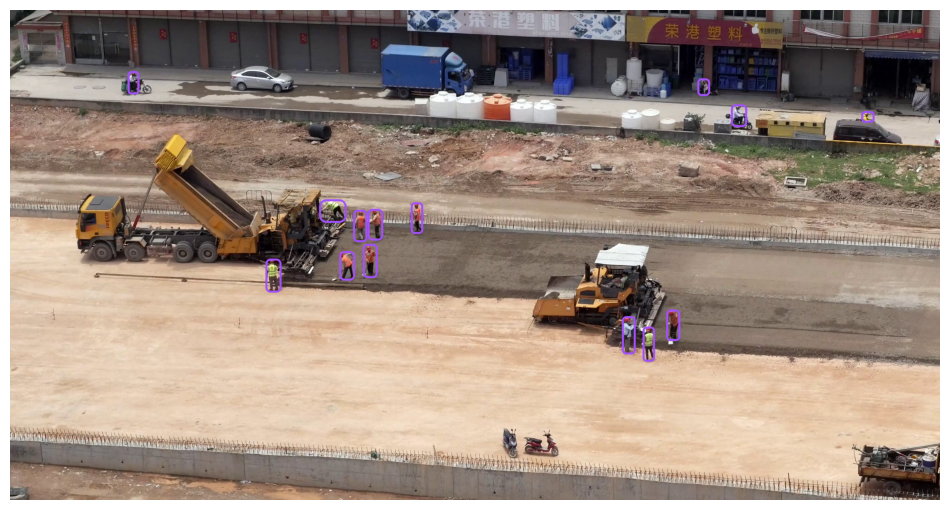

In [ ]:
from ultralytics import YOLO

frame = next(generator)

# Especificação do modelo
model = YOLO('yolov8x.pt')

# Detecção de objetos
results = model(frame, imgsz=1280)[0]
detections = sv.Detections.from_ultralytics(results)

# Detectar apenas pessoas
detections = detections[detections.class_id == 0]

# Bounding Box
round_box_annotator = sv.RoundBoxAnnotator(thickness=8)
annotated_frame = round_box_annotator.annotate(scene=frame, detections=detections)

sv.plot_image(frame)

Para conferir a lista de objetos detectáveis e seus respectivos `IDs`:

In [ ]:
results.names

# 4.1. Seleção da Região de Interesse

#5. Detecção de objetos em vídeo.

É realizada apenas a detecção de pessoas que estiverem dentro de uma zona definida.




In [ ]:
from ultralytics import YOLO
import numpy as np

def process_frame(frame:np.array, _) -> np.array:
  # Detecção de objetos
  results = model(frame, imgsz=1280)[0]
  detections = sv.Detections.from_ultralytics(results)

  # Detectar apenas pessoas
  detections = detections[detections.class_id == 0]

  # Extrair informações do vídeo
  video_info = sv.VideoInfo.from_video_path(video_path=VIDEO_PATH)

  # Definição da zona de interesse (ROI)
  # polygon = np.array([[675,255], [1080,257], [1132,615], [580,630]]) # people.mp4
  polygon = np.array([[491,712], [761,378], [1879,580], [1715,1017]]) # workers.mp4
  zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)

  # Disparar um gatilho sempre que houver alguma pessoa dentro da zona
  mask = zone.trigger(detections=detections)
  detections = detections[(detections.class_id == 0) & mask]

  # Anotações
  labels = [f"{model.names[class_id]},{confidence:0.2f}" for _, _, confidence, class_id, _, _ in detections]


  box_annotator = sv.BoxAnnotator(thickness=3, text_thickness=3, text_scale=1)
  zone_annotator = sv.PolygonZoneAnnotator(zone=zone, color=sv.Color.white(), thickness=6, text_thickness=6, text_scale=1)

  box_annotator.annotate(scene=frame, detections=detections, labels=labels)
  zone_annotator.annotate(scene=frame)

  return frame

# Resultado
sv.process_video(source_path=VIDEO_PATH, target_path="/content/result.mp4", callback=process_frame)